In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import torch
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results, AverageMeter
from torch.utils.data import DataLoader

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
path_to_data = 'asbestos'
# anno_stones = parse_anno_file(os.path.join(path_to_data, 'images', 'annotation.xml'))
anno_tr_stones = parse_anno_file(os.path.join(path_to_data, 'tr_stones', 'annotation', 'annotation.xml'), os.path.join(path_to_data, 'tr_stones', 'images'))

In [7]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

# stone_model = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
asbest_model_1 = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
# asbest_model_2 = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)

# stone_model.load_state_dict(torch.load('stone_asbest_segmentation.pth'))
# stone_model.eval();
asbest_model_1.load_state_dict(torch.load('asbest_segmentation_b3_v1.3.pth'))
asbest_model_1.eval();
# asbest_model_2.load_state_dict(torch.load('asbest_segmentation_b3_final.pth'))
# asbest_model_2.eval();

asbestos/tr_stones/images/11_11:59:20_16-03-2020_1.png


Text(0.5, 1.0, 'the inference mask of asbestos veins')

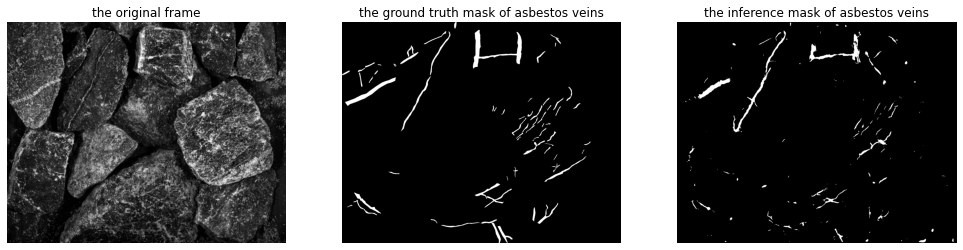

In [8]:
img_size=(1024, 1024)
index = 5
print(anno_tr_stones[index]['name'])


img = cv2.imread(anno_tr_stones[index]['name'], cv2.IMREAD_UNCHANGED)
tr_asb = create_mask_file(anno_tr_stones[index], 'asbest')

img, st, asb = big_image_predict(asbest_model_1, 
                                  img, 
                                  crop_size=img_size,
                                  inp_size=img_size,
                                  device=device
                                 )
plt.figure(figsize=(17,10), frameon=False)
plt.subplot(131)
plt.imshow(img, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the original frame')
plt.subplot(132)
plt.imshow(tr_asb, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the ground truth mask of asbestos veins')
plt.subplot(133)
plt.imshow(asb > 0.5, cmap=plt.cm.gray)
plt.axis('off')
plt.title('the inference mask of asbestos veins')
# plt.subplot(133)
# plt.imshow(asb)
# plt.savefig('graphics/asbestos.png', bbox_inches='tight', pad_inches=0)

In [14]:
manual_results = {'probes' : [], 'day' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}
net_results = {'probes' : [], 'day' : [], 'preds' : [], 'trues' : [], 'asbest' : [], 'stones' : []}

anno = anno_tr_stones

for it in anno:
    name = it['name'].split('/')[-1]
    if get_time(name).day != 16:
        continue
    probe = int(name.split('_')[0])
    if probe < 10 or probe > 14:
        continue
    st_mask = create_mask_file(it, 'stone', binary=True)
    asb_mask = create_mask_file(it, 'asbest', binary=True)
    manual_results['probes'].append(probe)
    manual_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    manual_results['asbest'].append(np.sum(asb_mask))
    manual_results['stones'].append(np.sum(st_mask))
    manual_results['trues'].append(true_results[16][probe])
    manual_results['day'].append(get_time(name).day)

for it in tqdm(anno, total=len(anno)):
    name = it['name'].split('/')[-1]
#     if get_time(name).day != 16:
#         continue
    probe = int(name.split('_')[0])
#     if probe < 10 or probe > 14:
#         continue
#                     probe = int(name.split('_')[0])
    img = cv2.imread(it['name'], cv2.IMREAD_UNCHANGED)
    _, _, asb_mask = big_image_predict(asbest_model_1, 
                                      img, 
                                      crop_size=(1024, 1024),
                                      inp_size=(1024, 1024),
                                      device=device
                                     )
#     _, st_mask, _ = big_image_predict(stone_model, 
#                                   img, 
#                                   crop_size=(img.shape[0] // 2, img.shape[1] // 2),
#                                   inp_size=(1024,1024),
#                                   device=device
#                                  )
#     st_mask = create_mask_file(it, 'stone', binary=True)
#     st_mask = st_mask > 0.1
    asb_mask = asb_mask > 0.3
#     asb_mask = create_mask_file(it, 'asbest')
    net_results['probes'].append(probe)
    net_results['preds'].append(100 * np.sum(asb_mask) / np.sum(st_mask))
    net_results['asbest'].append(np.sum(asb_mask))
    net_results['stones'].append(np.sum(st_mask))
    net_results['trues'].append(true_results[16][probe])
    net_results['day'].append(get_time(name).day)

100%|██████████| 134/134 [02:15<00:00,  1.01s/it]


[0.42333821 0.63543271]
[0.52378909 1.4161319 ]


Text(0, 0.5, 'Лабораторное содержание асбеста, %')

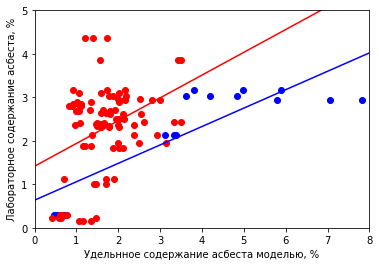

In [17]:
p_manual = np.polyfit(manual_results['preds'], manual_results['trues'], 1)
print(p_manual)
reg_manual = np.polyval(p_manual, [0, 10])

index = np.array(net_results['day']) == 16
p_net = np.polyfit(np.array(net_results['preds'])[index], np.array(net_results['trues'])[index], 1)
print(p_net)
reg_net = np.polyval(p_net, [0, 10])


plt.scatter(manual_results['preds'], manual_results['trues'], c='b')
plt.plot([0, 10], reg_manual, 'b')


plt.scatter(np.array(net_results['preds'])[index], np.array(net_results['trues'])[index], c='r')
plt.plot([0, 10], reg_net, 'r')
plt.xlim(0, 8)
plt.ylim(0, 5)
plt.xlabel('Удельнное содержание асбеста моделью, %')
plt.ylabel('Лабораторное содержание асбеста, %')